# DCN Goodreads Recommendation System

---
## Prepare the data

Setup

Setup logging

In [1]:
import logging
import datetime
LOGGING_FN = "old_wd_"
fn = os.path.join("./logs/", LOGGING_FN + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + ".log")

logging.basicConfig(filename=fn, format='%(asctime)s %(name)-12s %(levelname)-8s %(message)s',
                    datefmt='%d-%m %H:%M',
                    encoding='utf-8', level=logging.DEBUG)

# define a Handler which writes all messages to console, too
console = logging.StreamHandler()
console.setLevel(logging.INFO)
# set a format which is simpler for console use
formatter = logging.Formatter('%(asctime)s %(levelname)-8s %(message)s')
# tell the handler to use this format
console.setFormatter(formatter)
# add the handler to the root logger
logging.getLogger('').addHandler(console)

In [2]:
import os
os.environ["TF_ENABLE_ONEDNN_OPTS"] = '1'

In [3]:
import tensorflow as tf

import os

def get_mkl_enabled_flag():

    mkl_enabled = False
    major_version = int(tf.__version__.split(".")[0])
    minor_version = int(tf.__version__.split(".")[1])
    if major_version >= 2:
        if minor_version < 5:
            from tensorflow.python import _pywrap_util_port
        else:
            from tensorflow.python.util import _pywrap_util_port
            onednn_enabled = int(os.environ.get('TF_ENABLE_ONEDNN_OPTS', '0'))
        mkl_enabled = _pywrap_util_port.IsMklEnabled() or (onednn_enabled == 1)
    else:
        mkl_enabled = tf.pywrap_tensorflow.IsMklEnabled()
    return mkl_enabled

logging.info(f"We are using Tensorflow version {tf.__version__}")
logging.info(f"MKL enabled : {get_mkl_enabled_flag()}")



2022-03-05 20:10:58.877209: I tensorflow/core/util/util.cc:159] Experimental oneDNN custom operations are on. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-03-05 20:10:58.883340: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-05 20:10:58.883359: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-03-05 20:11:00,542 INFO     We are using Tensorflow version 2.8.0
2022-03-05 20:11:00,543 INFO     MKL enabled : True


In [7]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import datetime
import keras_tuner as kt

In [8]:
logging.info(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")

2022-03-05 20:11:47,495 INFO     Num GPUs Available: 0


Dataset Directory

In [9]:
MODEL_DIR = './models/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)
DIR = './data/cleaned/'

In [53]:
data = pd.read_pickle(os.path.join(DIR, "joined_df.pkl"))

In [54]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 981705 entries, 5e212a62bced17b4dbe41150e5bb9037 to e25d87abdb0bddcda1193034e54f819e
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   user_id             981705 non-null  object 
 1   book_id             981705 non-null  uint32 
 2   rating              981705 non-null  uint8  
 3   review_text         981705 non-null  string 
 4   title               981705 non-null  string 
 5   text_reviews_count  981705 non-null  uint64 
 6   average_rating      981705 non-null  float64
 7   description         981705 non-null  string 
 8   author_id           981705 non-null  int64  
dtypes: float64(1), int64(1), object(1), string(3), uint32(1), uint64(1), uint8(1)
memory usage: 64.6+ MB


In [55]:
DATA_LIMIT = 100000

In [56]:
for col in data.columns:
    logging.info(f"unique {col}: {data[col].nunique()}")

2022-03-05 20:34:42,553 INFO     unique user_id: 93480
2022-03-05 20:34:42,567 INFO     unique book_id: 152258
2022-03-05 20:34:42,573 INFO     unique rating: 6
2022-03-05 20:34:44,355 INFO     unique review_text: 956133
2022-03-05 20:34:44,443 INFO     unique title: 99813
2022-03-05 20:34:44,452 INFO     unique text_reviews_count: 1715
2022-03-05 20:34:44,461 INFO     unique average_rating: 296
2022-03-05 20:34:45,464 INFO     unique description: 123034
2022-03-05 20:34:45,479 INFO     unique author_id: 25548


only use small subset of data for training

In [57]:
seed = 42

data = data.iloc[:DATA_LIMIT, :]
# data_subset = data.sample(frac=1, random_state=seed).iloc[:DATA_LIMIT, :]

In [58]:
logging.info(data.info())

2022-03-05 20:34:49,164 INFO     None


<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 5e212a62bced17b4dbe41150e5bb9037 to e77d4ff5fb4bb5c03f97912e834f75a8
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   user_id             100000 non-null  object 
 1   book_id             100000 non-null  uint32 
 2   rating              100000 non-null  uint8  
 3   review_text         100000 non-null  string 
 4   title               100000 non-null  string 
 5   text_reviews_count  100000 non-null  uint64 
 6   average_rating      100000 non-null  float64
 7   description         100000 non-null  string 
 8   author_id           100000 non-null  int64  
dtypes: float64(1), int64(1), object(1), string(3), uint32(1), uint64(1), uint8(1)
memory usage: 6.6+ MB


In [59]:
# train_data_file = "train_data.csv"
# test_data_file = "test_data.csv"
# alternatively, read the separated train/test files for repeatability
# train_data.to_csv(os.path.join(DIR, train_data_file), index=False)
# test_data.to_csv(os.path.join(DIR, test_data_file), index=False)

Let's split the data into training (70%), validation (15%) and test (15%) sets.

In [60]:
TARGET_FEATURE_NAME = "rating"  # individual rating
train_split = 0.7
test_val_split = 0.15 
seed = 42
np.random.seed(seed)

In [61]:
train_data, val_data, test_data = np.split(data.sample(frac=1, random_state=seed), 
                       [int(train_split*len(data)), int((1-test_val_split)*len(data))])
# splits into data[:train_split], data[train_split:test_split], data[test_split:]
logging.info(f"Train split size: {len(train_data.index)}")
logging.info(f"Validation split size: {len(val_data.index)}")
logging.info(f"Test split size: {len(test_data.index)}")

2022-03-05 20:34:55,235 INFO     Train split size: 70000
2022-03-05 20:34:55,236 INFO     Validation split size: 15000
2022-03-05 20:34:55,237 INFO     Test split size: 15000


Now about 980k in Total, Train: 687k, Validation, Test: 147k :)

In [62]:
CSV_HEADER = list(train_data.columns)

---
## Define dataset metadata
Here, we define the metadata of the dataset that will be useful for reading and parsing the data into input features, and encoding the input features with respect to their types.



In [78]:
# normalization
NUMERIC_FEATURE_NAMES = [
    "text_reviews_count",   # popularity
    "average_rating"
]
# text vectorization + embedding
TEXT_FEATURE_NAMES = [
    "review_text",
    "title",
    "description",
]
# integer lookup
CATEGORICAL_INT_FEATURE_NAMES = [
    "book_id",
    "author_id",
]
# string lookup
CATEGORICAL_STR_FEATURE_NAMES = [
    "user_id",
]
CATEGORICAL_FEATURES_WITH_VOCABULARY = {
    "user_id": list(data["user_id"].unique()),
    "author_id": list(data["author_id"].unique()),
    "book_id": list(data["book_id"].unique()),
}


FEATURE_NAMES = CATEGORICAL_STR_FEATURE_NAMES + \
                CATEGORICAL_INT_FEATURE_NAMES + \
                TEXT_FEATURE_NAMES + \
                NUMERIC_FEATURE_NAMES

COLUMN_DEFAULTS = [
    [0] if feature_name in NUMERIC_FEATURE_NAMES + [TARGET_FEATURE_NAME] else ["NA"]
    for feature_name in CSV_HEADER
]


NUM_CLASSES = 1

In [79]:
logging.info("using features: ")
logging.info(FEATURE_NAMES)

2022-03-05 20:51:58,150 INFO     using features: 
2022-03-05 20:51:58,153 INFO     ['user_id', 'book_id', 'author_id', 'review_text', 'title', 'description', 'text_reviews_count', 'average_rating']


---
## Experiment setup
Next, let's define an input function that reads and parses the file, then converts features and labels into a `tf.data.Dataset` for training or evaluation.



In [80]:
def get_dataset_from_pandas(dataframe, label_name, batch_size, shuffle=False):
    df = dataframe.copy()
    labels = df.pop(label_name)
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.cache()
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [103]:
import tensorflow_recommenders as tfrs


class GoodreadsDCNModel(tfrs.models.Model):

    def __init__(self, num_cross_layers, deep_layer_sizes, projection_dim=None, embedding_dim=32, max_text_tokens=20_000, name=None):
        super().__init__(name)
        self.embedding_dimension = embedding_dim

        self._all_features = FEATURE_NAMES
        self._embeddings = {}
        self._dense = {}

        for i, feature_name in enumerate(self._all_features):
            # Compute embeddings for string features.
            if feature_name in CATEGORICAL_STR_FEATURE_NAMES:
                vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
                self._embeddings[feature_name] = tf.keras.Sequential(
                    [tf.keras.layers.StringLookup(
                        vocabulary=vocabulary, mask_token=None, name=f"str_lookup_{feature_name}_{i}"),
                    tf.keras.layers.Embedding(len(vocabulary) + 1,
                                            self.embedding_dimension, name=f"embedding_{feature_name}_{i}")
                    ])
            # Compute embeddings for complex text features.
            elif feature_name in TEXT_FEATURE_NAMES:
                self._embeddings[feature_name] = tf.keras.Sequential([
                    tf.keras.layers.TextVectorization(max_tokens=max_text_tokens, name=f"textvectorization_{feature_name}_{i}"),
                    tf.keras.layers.Embedding(max_text_tokens, self.embedding_dimension,  mask_zero=True, name=f"embedding_{feature_name}_{i}"),
                    tf.keras.layers.GlobalAveragePooling1D(),
                    ])

            # Compute embeddings for int features.
            elif feature_name in CATEGORICAL_INT_FEATURE_NAMES:
                vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
                self._embeddings[feature_name] = tf.keras.Sequential(
                    [tf.keras.layers.IntegerLookup(
                        vocabulary=vocabulary, mask_token=None, name=f"int_lookup_{feature_name}_{i}"),
                    tf.keras.layers.Embedding(len(vocabulary) + 1,
                                            self.embedding_dimension, name=f"embedding_{feature_name}_{i}")
                    ])
            # Normalize dense numeric features.
            elif feature_name in NUMERIC_FEATURE_NAMES:
                self._dense[feature_name] = tf.keras.layers.Normalization(axis=None)

            else:
                logging.warning(f"unknown feature type: {feature_name}")
                
        if num_cross_layers > 0:
            self._cross_layers = [tfrs.layers.dcn.Cross(
                projection_dim=projection_dim,
                kernel_initializer="glorot_uniform")
                        for _ in range(num_cross_layers)]
        else:
            self._cross_layers = None

        self._deep_layers = [tf.keras.layers.Dense(layer_size, activation="relu")
                             for layer_size in deep_layer_sizes]

        self._logit_layer = tf.keras.layers.Dense(1)

        self.task = tfrs.tasks.Ranking(
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.RootMeanSquaredError()]
        )

    def adapt_text_vec(self, feature_name:str, data):
        self._embeddings[feature_name].layers[0].adapt(data)

    # def adapt_numeric(self, feature_name:str, data):
    #     self._dense[feature_name].adapt(data)

    def call(self, features):
        # Concatenate embeddings
        layers = []
        for feature_name in self._all_features:
            try:
                embedding_fn = self._embeddings[feature_name]
                layers.append(embedding_fn(features[feature_name]))
            except KeyError:
                continue
                # dense_fn = self._dense[feature_name]
                # layers.append(dense_fn(features[feature_name]))
                
        x = tf.concat(layers, axis=1)

        # Build Cross Network
        if self._cross_layers is not None:
            for cross_layer in self._cross_layers:
                x = cross_layer(x)

        # Build Deep Network
        for deep_layer in self._deep_layers:
            x = deep_layer(x)

        return self._logit_layer(x)

    def compute_loss(self, features, training=False):
        labels = features.pop(TARGET_FEATURE_NAME)
        scores = self(features)
        return self.task(
            labels=labels,
            predictions=scores,
        )


In [104]:
def setup_model(hp: kt.HyperParameters, model_name=None):
  from tqdm.notebook import tqdm

  hp_num_deep = hp.Int("num_deep", 1, 4)
  hp_deep_size = hp.Choice("deep_size", [32, 128, 256, 512])
  hp_optimizer = hp.Fixed("optimizer", 'adam')
  # hp_optimizer = hp.Choice("optimizer", ['adam', 'adagrad'])
  hp_learning_rate = hp.Choice("learning_rate", [1e-4, 1e-3, 1e-2, 1e-1])
  hp_num_cross = hp.Int("num_cross_layer", 1, 4)
  hp_projection_dim = hp.Choice("projection_dim", [32, 64, 128])

  deep_layers = np.repeat(hp_deep_size, hp_num_deep)
  model = GoodreadsDCNModel(num_cross_layers=hp_num_cross,
              deep_layer_sizes=deep_layers,
              projection_dim=hp_projection_dim, name=model_name)
  
  # if len(model._embeddings["description"].layers[0].get_vocabulary()) < 10:
    # logging.info("adapting text vectorization layers to vocabulary..")
    # for feature_name in tqdm(TEXT_FEATURE_NAMES):
      # model.adapt_text_vec(feature_name, data[feature_name])
    # save the vocabulary for next time
    # for feature_name in TEXT_FEATURE_NAMES:
    #   vocab = model._embeddings[feature_name].layers[0].get_vocabulary()
    #   with open(f"./data/vocab_{feature_name}_datalimit_{DATA_LIMIT}.txt", "w") as outfile:
    #       outfile.write("\n".join(vocab))

#   for feature_name in NUMERIC_FEATURE_NAMES:
#       model.adapt_numeric(feature_name, data[feature_name])
  if hp_optimizer == 'adam':
      optimizer_instance = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)
  elif hp_optimizer == 'adagrad':
      optimizer_instance = tf.keras.optimizers.Adagrad(learning_rate=hp_learning_rate)
  model.compile(
      optimizer=optimizer_instance,
  )

  return model

todo: remove initial "\n" from vocab file

---
### Hyperparameter Tuning using Keras Tuner ~~HParams~~ and TensorBoard

In [105]:
import keras_tuner as kt
from tensorflow import keras
from keras_tuner import HyperParameters as hp

In [106]:
model = setup_model(kt.HyperParameters())

In [53]:
try:
    logging.info(f"description vocabulary size: {len(model._embeddings['description'].layers[0].get_vocabulary())}")
except KeyError:
    pass

In [107]:
tuner = kt.Hyperband(setup_model,
                     objective=kt.Objective('val_root_mean_squared_error', direction='min'),
                     max_epochs=50,
                     factor=3,
                     directory='models',
                     project_name='hyperband_w_text')


In [57]:
tuner.search_space_summary()

Search space summary
Default search space size: 6
num_deep (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': None}
deep_size (Choice)
{'default': 32, 'conditions': [], 'values': [32, 128, 256, 512], 'ordered': True}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'adagrad'], 'ordered': False}
learning_rate (Choice)
{'default': 0.0001, 'conditions': [], 'values': [0.0001, 0.001, 0.01, 0.1], 'ordered': True}
num_cross_layer (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': None}
projection_dim (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128], 'ordered': True}


In [60]:
# defining a call that will clean out output at the end of every training epoch
from IPython.display import clear_output

class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        clear_output(wait = True)


In [61]:
import datetime
import tensorflow_addons as tfa

epochs = 50
batch_size = 512
train_dataset = get_dataset_from_pandas(train_data, TARGET_FEATURE_NAME, batch_size, shuffle=True).map(lambda x, y: {
  "book_id": x["book_id"],
  "author_id": x["author_id"],
  "user_id": x["user_id"],
  # "review_text": x["review_text"],
  # "title": x["title"],
  # "description": x["description"],
  # "text_reviews_count": x["text_reviews_count"],
  # "average_rating": x["average_rating"],
  "rating": y,
})
validation_dataset = get_dataset_from_pandas(val_data, TARGET_FEATURE_NAME, batch_size).map(lambda x, y: {
  "book_id": x["book_id"],
  "author_id": x["author_id"],
  "user_id": x["user_id"],
  # "review_text": x["review_text"],
  # "title": x["title"],
  # "description": x["description"],
  # "text_reviews_count": x["text_reviews_count"],
  # "average_rating": x["average_rating"],
  "rating": y,
})

log_dir = "logs/fit/" + "hp_tuning_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

callbacks_train = [
    tf.keras.callbacks.TensorBoard(log_dir=log_dir),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
    tfa.callbacks.TQDMProgressBar(update_per_second=2, leave_epoch_progress = False),
    ClearTrainingOutput(),
]

logging.info("Start training the model...")


tuner.search(
    train_dataset, 
    epochs=epochs, 
    callbacks=callbacks_train,
    validation_data=validation_dataset, verbose=0)
logging.info("Model training finished")


2022-02-25 12:51:53,964 INFO     Oracle triggered exit
2022-02-25 12:51:53,965 INFO     Model training finished


In [75]:
tuner.results_summary()

Results summary
Results in models/hyperband_no_text
Showing 10 best trials
Objective(name='val_root_mean_squared_error', direction='min')
Trial summary
Hyperparameters:
num_deep: 4
deep_size: 256
optimizer: adam
learning_rate: 0.01
num_cross_layer: 3
projection_dim: 128
tuner/epochs: 6
tuner/initial_epoch: 2
tuner/bracket: 3
tuner/round: 1
tuner/trial_id: 52957cb37376e188343e5d40165f808e
Score: 1.1253809928894043
Trial summary
Hyperparameters:
num_deep: 1
deep_size: 32
optimizer: adam
learning_rate: 0.01
num_cross_layer: 3
projection_dim: 64
tuner/epochs: 6
tuner/initial_epoch: 2
tuner/bracket: 3
tuner/round: 1
tuner/trial_id: 5ff88e6dd7fcb0f15d80385de8cd5ed5
Score: 1.12763249874115
Trial summary
Hyperparameters:
num_deep: 2
deep_size: 128
optimizer: adam
learning_rate: 0.001
num_cross_layer: 3
projection_dim: 32
tuner/epochs: 6
tuner/initial_epoch: 2
tuner/bracket: 3
tuner/round: 1
tuner/trial_id: 24301673861b77fa53d36d45aa9157df
Score: 1.131394624710083
Trial summary
Hyperparameters:

In [78]:
# build the best model and train it
logging.info("training the best model config on whole dataset...")
# grab the best hyperparameters
bestHP = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(bestHP)

log_dir = "logs/fit/" + "hp_tuning_best_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir=log_dir),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),
    tfa.callbacks.TQDMProgressBar(update_per_second=2, leave_epoch_progress = False),
]


H = model.fit(train_dataset, 
    epochs=epochs, 
    callbacks=callbacks,
    validation_data=validation_dataset, verbose=1)

2022-02-25 13:30:10,151 INFO     training the best model config on whole dataset...


Training:   0%|           0/50 ETA: ?s,  ?epochs/s

Epoch 1/50


0/137           ETA: ?s - 

Epoch 1/50
  5/137 [>.............................] - ETA: 6s - root_mean_squared_error: 4.1942 - loss: 17.5916 - regularization_loss: 0.0000e+00 - total_loss: 17.5916

2022-02-25 13:30:12,403 WARNING  Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0146s vs `on_train_batch_end` time: 0.0376s). Check your callbacks.


137/137 [==============================] - 8s 50ms/step - root_mean_squared_error: 1.7006 - loss: 2.8781 - regularization_loss: 0.0000e+00 - total_loss: 2.8781 - val_root_mean_squared_error: 1.1230 - val_loss: 1.1132 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.1132
Epoch 2/50


0/137           ETA: ?s - 

Epoch 2/50
137/137 [==============================] - 6s 47ms/step - root_mean_squared_error: 0.9327 - loss: 0.8690 - regularization_loss: 0.0000e+00 - total_loss: 0.8690 - val_root_mean_squared_error: 1.1579 - val_loss: 1.1771 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.1771
Epoch 3/50


0/137           ETA: ?s - 

Epoch 3/50
137/137 [==============================] - 6s 46ms/step - root_mean_squared_error: 0.8530 - loss: 0.7272 - regularization_loss: 0.0000e+00 - total_loss: 0.7272 - val_root_mean_squared_error: 4.2739 - val_loss: 1.0945 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.0945
Epoch 4/50


0/137           ETA: ?s - 

Epoch 4/50
137/137 [==============================] - 6s 47ms/step - root_mean_squared_error: 16.2602 - loss: 261.9548 - regularization_loss: 0.0000e+00 - total_loss: 261.9548 - val_root_mean_squared_error: 1.7821 - val_loss: 1.1931 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.1931
Epoch 5/50


0/137           ETA: ?s - 

Epoch 5/50
137/137 [==============================] - 6s 47ms/step - root_mean_squared_error: 9.7332 - loss: 93.8703 - regularization_loss: 0.0000e+00 - total_loss: 93.8703 - val_root_mean_squared_error: 1.1854 - val_loss: 1.1830 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.1830
Epoch 6/50


0/137           ETA: ?s - 

Epoch 6/50
137/137 [==============================] - 7s 48ms/step - root_mean_squared_error: 694.5298 - loss: 477893.7069 - regularization_loss: 0.0000e+00 - total_loss: 477893.7069 - val_root_mean_squared_error: 1.1841 - val_loss: 1.1743 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.1743
Epoch 7/50


0/137           ETA: ?s - 

Epoch 7/50
137/137 [==============================] - 6s 46ms/step - root_mean_squared_error: 16851450.0000 - loss: 281334845621886.9688 - regularization_loss: 0.0000e+00 - total_loss: 281334845621886.9688 - val_root_mean_squared_error: 1.1834 - val_loss: 1.1783 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.1783
Epoch 8/50


0/137           ETA: ?s - 

Epoch 8/50
137/137 [==============================] - 6s 47ms/step - root_mean_squared_error: 1.1918 - loss: 1.4217 - regularization_loss: 0.0000e+00 - total_loss: 1.4217 - val_root_mean_squared_error: 1.1814 - val_loss: 1.1726 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.1726
Epoch 9/50


0/137           ETA: ?s - 

Epoch 9/50
137/137 [==============================] - 6s 47ms/step - root_mean_squared_error: 1.1862 - loss: 1.4084 - regularization_loss: 0.0000e+00 - total_loss: 1.4084 - val_root_mean_squared_error: 1.1867 - val_loss: 1.1827 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.1827
Epoch 10/50


0/137           ETA: ?s - 

Epoch 10/50
137/137 [==============================] - 7s 48ms/step - root_mean_squared_error: 1.1850 - loss: 1.4055 - regularization_loss: 0.0000e+00 - total_loss: 1.4055 - val_root_mean_squared_error: 1.1886 - val_loss: 1.1867 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.1867
Epoch 11/50


0/137           ETA: ?s - 

Epoch 11/50
137/137 [==============================] - 6s 47ms/step - root_mean_squared_error: 1.1846 - loss: 1.4044 - regularization_loss: 0.0000e+00 - total_loss: 1.4044 - val_root_mean_squared_error: 1.1886 - val_loss: 1.1867 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.1867
Epoch 12/50


0/137           ETA: ?s - 

Epoch 12/50
137/137 [==============================] - 6s 46ms/step - root_mean_squared_error: 1.1843 - loss: 1.4037 - regularization_loss: 0.0000e+00 - total_loss: 1.4037 - val_root_mean_squared_error: 1.1884 - val_loss: 1.1863 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.1863
Epoch 13/50


0/137           ETA: ?s - 

Epoch 13/50
137/137 [==============================] - 6s 45ms/step - root_mean_squared_error: 1.1841 - loss: 1.4034 - regularization_loss: 0.0000e+00 - total_loss: 1.4034 - val_root_mean_squared_error: 1.1882 - val_loss: 1.1859 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.1859


In [80]:
test_dataset = get_dataset_from_pandas(test_data, TARGET_FEATURE_NAME, 512).map(lambda x, y: {
    "book_id": x["book_id"],
    "author_id": x["author_id"],
    "user_id": x["user_id"],
    # "review_text": x["review_text"],
    # "title": x["title"],
    # "description": x["description"],
    # "text_reviews_count": x["text_reviews_count"],
    # "average_rating": x["average_rating"],
    "rating": y,
  })
metrics = model.evaluate(test_dataset, return_dict=True, callbacks=[tfa.callbacks.TQDMProgressBar()], verbose=1)

print(metrics)


0/30           ETA: ?s - Evaluating

 5/30 [====>.........................] - ETA: 0s - root_mean_squared_error: 1.1885 - loss: 1.4125 - regularization_loss: 0.0000e+00 - total_loss: 1.4125

2022-02-25 13:37:06,757 WARNING  Callback method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0060s vs `on_test_batch_end` time: 0.0291s). Check your callbacks.


30/30 [==============================] - 1s 35ms/step - root_mean_squared_error: 1.1974 - loss: 1.4338 - regularization_loss: 0.0000e+00 - total_loss: 1.4338
{'root_mean_squared_error': 1.1973897218704224, 'loss': 1.4338858127593994, 'regularization_loss': 0, 'total_loss': 1.4338858127593994}


In [91]:
iterator = train_dataset.as_numpy_iterator()
x = next(iterator)
x

{'book_id': array([  153025, 14740588, 32283133, 22609317,  2277378, 18214414,
        16160797, 18812405, 25251757,  6892870,   338691, 17212231,
         9736930,      968,   105992,  8442457,    16299, 22557272,
        14568987,  6411961,    16243,  6587879,  9736930,    16328,
        19288043, 28187230, 16130549, 10680329, 22557272,  6587879,
        15729539,  9736930, 31450633, 28187230,    18342, 19561922,
        23016520, 14568987,  6115138,  6652906, 16160797, 19288043,
          153025, 32283133, 27833670, 19288043, 18920446,  2429135,
        19486412, 19486412,    29044,  6218281,      968, 17860739,
         7327811,  8628133,      960, 31450633,    39799, 28187230,
          153025,  9736930,  6115138,  2429135, 28187230, 20550148,
        15729539, 23492288, 18214414,    18342, 18656036,     6427,
        17212231, 22609317, 19288043,  2459785,  8442457,    10603,
        15793165,    21686, 15729539, 24586590, 22557272,    89724,
           16243,    31304, 22557272,

In [113]:
single = {key: x[key][:2] for key in x.keys()}

In [114]:
single

{'book_id': array([  153025, 14740588], dtype=uint32),
 'author_id': array([88506,  2384]),
 'user_id': array([b'92c52514ddadaabec37eb1ab8d3710c9',
        b'fae09e1795635ee17df6f2f40e67929e'], dtype=object),
 'rating': array([4, 3], dtype=uint8)}

In [100]:
model.predict(tf.data.Dataset.from_tensors(single))

array([[3.5775568]], dtype=float32)

In [82]:
from email_callback import send_hyperparameter_results_email

send_hyperparameter_results_email(tuner, model)

Model: "goodreads_dcn_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_8 (Sequential)   (None, 32)                9856      
                                                                 
 sequential_7 (Sequential)   (None, 32)                22144     
                                                                 
 sequential_6 (Sequential)   (None, 32)                1311040   
                                                                 
 cross_6 (Cross)             multiple                  24672     
                                                                 
 cross_7 (Cross)             multiple                  24672     
                                                                 
 cross_8 (Cross)             multiple                  24672     
                                                                 
 dense_10 (Dense)            multiple        

In [101]:
FEATURE_NAMES

['user_id', 'book_id', 'author_id']

In [103]:
TEXT_FEATURE_NAMES + CATEGORICAL_STR_FEATURE_NAMES

['review_text', 'title', 'description', 'user_id']

## Alternative: DLRM

WIP

In [116]:
import tensorflow_recommenders as tfrs


class GoodreadsDLRMModel(tfrs.models.Model):

    def __init__(self, num_cross_layers, deep_layer_sizes= [256,128,64], embedding_dim=32, max_text_tokens=20_000, name=None):
        super().__init__(name)
        self.embedding_dimension = embedding_dim

        self._all_features = FEATURE_NAMES
        self._embeddings = {}

        # create embeddings for categorical features for deep model

        for i, feature_name in enumerate(self._all_features):
            # Compute embeddings for string features.
            if feature_name in CATEGORICAL_STR_FEATURE_NAMES:
                vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
                self._embeddings[feature_name] = tf.keras.Sequential(
                    [tf.keras.layers.StringLookup(
                        vocabulary=vocabulary, mask_token=None, name=f"str_lookup_{feature_name}_{i}"),
                    tf.keras.layers.Embedding(len(vocabulary) + 1,
                                            self.embedding_dimension, name=f"embedding_{feature_name}_{i}")
                    ])
            # Compute embeddings for complex text features.
            elif feature_name in TEXT_FEATURE_NAMES:
                self._embeddings[feature_name] = tf.keras.Sequential([
                    tf.keras.layers.TextVectorization(max_tokens=max_text_tokens, name=f"textvectorization_{feature_name}_{i}"),
                    tf.keras.layers.Embedding(max_text_tokens, self.embedding_dimension,  mask_zero=True, name=f"embedding_{feature_name}_{i}"),
                    tf.keras.layers.GlobalAveragePooling1D(),
                    ])

            # Compute embeddings for int features.
            elif feature_name in CATEGORICAL_INT_FEATURE_NAMES:
                vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
                self._embeddings[feature_name] = tf.keras.Sequential(
                    [tf.keras.layers.IntegerLookup(
                        vocabulary=vocabulary, mask_token=None, name=f"int_lookup_{feature_name}_{i}"),
                    tf.keras.layers.Embedding(len(vocabulary) + 1,
                                            self.embedding_dimension, name=f"embedding_{feature_name}_{i}")
                    ])


            else:
                logging.warning(f"unknown feature type: {feature_name}")
        
        # # CONTINUOUS FEATURES
        # # Normalize dense numeric features.
        # for i, feature_name in enumerate(self._wide_features):
        #     self._wide[feature_name] = tf.keras.layers.Normalization(axis=None)
                
        if num_cross_layers > 0:
            self._cross_layers = [tfrs.layers.feature_interaction.DotInteraction(
                self_interaction=True,skip_gather=True)
                        for _ in range(num_cross_layers)]
        else:
            self._cross_layers = None

        self._deep_layers = [tf.keras.layers.Dense(layer_size, activation="relu")
                             for layer_size in deep_layer_sizes]

        self._logit_layer = tf.keras.layers.Dense(1)

        self.task = tfrs.tasks.Ranking(
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.RootMeanSquaredError()]
        )

    def adapt_text_vec(self, feature_name:str, data):
        self._embeddings[feature_name].layers[0].adapt(data)

    # def adapt_numeric(self, feature_name:str, data):
    #     self._dense[feature_name].adapt(data)

    def call(self, features):
        # Concatenate embeddings
        layers = []
        for feature_name in self._all_features:
            try:
                embedding_fn = self._embeddings[feature_name]
                layers.append(embedding_fn(features[feature_name]))
            except KeyError:
                continue
                # dense_fn = self._dense[feature_name]
                # layers.append(dense_fn(features[feature_name]))
                
        x = tf.concat(layers, axis=1)

        # Build Cross Network
        if self._cross_layers is not None:
            for cross_layer in self._cross_layers:
                x = cross_layer(x)

        # Build Deep Network
        for deep_layer in self._deep_layers:
            x = deep_layer(x)

        return self._logit_layer(x)

    def compute_loss(self, features, training=False):
        labels = features.pop(TARGET_FEATURE_NAME)
        scores = self(features)
        return self.task(
            labels=labels,
            predictions=scores,
        )


In [117]:
def setup_dlrm(hp: kt.HyperParameters, model_name=None):
  from tqdm.notebook import tqdm

  hp_num_deep = hp.Int("num_deep", 1, 4)
  hp_deep_size = hp.Choice("deep_size", [32, 128, 256, 512])
  hp_optimizer = hp.Choice("optimizer", ['adam', 'adagrad'])
  hp_learning_rate = hp.Choice("learning_rate", [1e-4, 1e-3, 1e-2, 1e-1])
  hp_num_cross = hp.Int("num_cross_layer", 1, 4)

  deep_layers = np.repeat(hp_deep_size, hp_num_deep)
  model = GoodreadsDLRMModel(num_cross_layers=hp_num_cross,
              deep_layer_sizes=deep_layers,
              name=model_name)
  
  # if len(model._embeddings["description"].layers[0].get_vocabulary()) < 10:
    # logging.info("adapting text vectorization layers to vocabulary..")
    # for feature_name in tqdm(TEXT_FEATURE_NAMES):
      # model.adapt_text_vec(feature_name, data[feature_name])
    # save the vocabulary for next time
    # for feature_name in TEXT_FEATURE_NAMES:
    #   vocab = model._embeddings[feature_name].layers[0].get_vocabulary()
    #   with open(f"./data/vocab_{feature_name}_datalimit_{DATA_LIMIT}.txt", "w") as outfile:
    #       outfile.write("\n".join(vocab))

#   for feature_name in NUMERIC_FEATURE_NAMES:
#       model.adapt_numeric(feature_name, data[feature_name])
  if hp_optimizer == 'adam':
      optimizer_instance = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)
  elif hp_optimizer == 'adagrad':
      optimizer_instance = tf.keras.optimizers.Adagrad(learning_rate=hp_learning_rate)
  model.compile(
      optimizer=optimizer_instance,
  )

  return model

In [118]:
model = setup_dlrm(kt.HyperParameters())

In [119]:
model.call(single)
model.summary()

2022-02-25 15:43:13.675584: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at strided_slice_op.cc:108 : INVALID_ARGUMENT: slice index 1 of dimension 0 out of bounds.


InvalidArgumentError: Exception encountered when calling layer "dot_interaction_1" (type DotInteraction).

slice index 1 of dimension 0 out of bounds. [Op:StridedSlice] name: dot_interaction_1/strided_slice/

Call arguments received:
  • inputs=tf.Tensor(shape=(2, 96), dtype=float32)

In [ ]:
tuner = kt.Hyperband(setup_dlrm,
                     objective=kt.Objective('val_root_mean_squared_error', direction='min'),
                     max_epochs=50,
                     factor=3,
                     directory='models',
                     project_name='hyperband_dlrm_no_text')


---
### Old Setup

In [81]:
def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        if feature_name in [*TEXT_FEATURE_NAMES, *CATEGORICAL_STR_FEATURE_NAMES]:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.string
            )
        else:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.float32
            )
    return inputs

In [82]:
# Model constants.
max_features = 20000
embedding_dim = 128
sequence_length = 500

In [83]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding

In [84]:
from tensorflow.keras.layers import StringLookup, IntegerLookup

call = 1
def encode_inputs(inputs, use_embedding=False):
    global call
    call += 1
    encoded_features = []
    for feature_name in inputs:
        if feature_name in [*CATEGORICAL_STR_FEATURE_NAMES, *CATEGORICAL_INT_FEATURE_NAMES]:
            is_string = (feature_name in CATEGORICAL_STR_FEATURE_NAMES)
            lookup_class = StringLookup if is_string else IntegerLookup
            lookup_name = "string_lookup" if is_string else "integer_lookup"
            vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
            lookup = lookup_class(
                vocabulary=vocabulary,
                output_mode="int" if use_embedding else "multi_hot",
                name=f"{lookup_name}_{feature_name}_{call}",
            )
            if use_embedding:
                # Convert the string input values into integer indices.
                encoded_feature = lookup(inputs[feature_name])
                embedding_dims = 32 #int(math.sqrt(len(vocabulary)))
                # Create an embedding layer with the specified dimensions.
                embedding = layers.Embedding(
                    input_dim=len(vocabulary)+1, output_dim=embedding_dims,
                    name=f"{lookup_name}_embedding_{feature_name}_{call}",
                )
                
                # Convert the index values to embedding representations.
                encoded_feature = embedding(encoded_feature)
            else:
                # Convert the string input values into a one hot encoding.
                encoded_feature = lookup(tf.expand_dims(inputs[feature_name], -1))
        elif feature_name in TEXT_FEATURE_NAMES:
            vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=max_features, 
            output_sequence_length=sequence_length if use_embedding else None, output_mode="int" if use_embedding else "multi_hot",
            name=f"textvectorization_{feature_name}_{call}",
            )
            vectorize_layer.adapt(data[feature_name])
            if use_embedding:
                # Convert the string input values into integer indices.
                encoded_feature = vectorize_layer(inputs[feature_name])
                embedding_dims = 32 #int(math.sqrt(len(vocabulary)))
                # Create an embedding layer with the specified dimensions.
                embedding = layers.Embedding(
                    input_dim=vectorize_layer.vocabulary_size()+1, output_dim=embedding_dims,
                    name=f"tv_embedding_{feature_name}_{call}",
                )
                # average the embedding from sequence_length x batch to 1x32
                averaging = tf.keras.layers.GlobalAveragePooling1D();

                # Convert the index values to embedding representations.
                encoded_feature = averaging(embedding(encoded_feature))
            else:
                # Convert the string input values into a one hot encoding.
                encoded_feature = vectorize_layer(tf.expand_dims(inputs[feature_name], -1))
        else:
            # Use the numerical features as-is.
            encoded_feature = tf.expand_dims(inputs[feature_name], -1)

        encoded_features.append(encoded_feature)
        
    all_features = layers.concatenate(encoded_features)
    return all_features


In [85]:
model_inputs = create_model_inputs()
model_features = encode_inputs(model_inputs)
embedded_features = encode_inputs(model_inputs, use_embedding=True)

In [100]:
from email_callback import EmailCallback
dropout_rate = 0.2

hidden_units = [32, 32]
EmailCallback()

def run_experiment(model, loss=None, metrics=None, learning_rate=0.01, batch_size=128, num_epochs=20):
    import datetime
    _loss = loss if loss is not None else [tf.keras.losses.MeanSquaredError()]
    _metrics = metrics if metrics is not None else [tf.keras.metrics.RootMeanSquaredError()]
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=_loss,
        metrics=_metrics,
    )

    train_dataset = get_dataset_from_pandas(train_data, TARGET_FEATURE_NAME, batch_size, shuffle=True)
    validation_dataset = get_dataset_from_pandas(val_data, TARGET_FEATURE_NAME, batch_size)

    log_dir = "logs/fit/" + model.name + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    email = EmailCallback(train_size=len(train_data), val_size=len(val_data))
    callbacks_train = [
        tf.keras.callbacks.TensorBoard(log_dir=log_dir),
        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5, min_delta=0.001),
        tf.keras.callbacks.EarlyStopping(monitor="loss",patience=5),
        tf.keras.callbacks.BackupAndRestore(backup_dir="./models/backup"+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S")),
        email
    ]

    print("Start training the model...")
    history = model.fit(
        train_dataset, 
        epochs=num_epochs, 
        callbacks=callbacks_train,
        validation_data=validation_dataset)
    print("Model training finished")

    print(metrics)

    return history, metrics


setting up yagmail...


In [87]:
PLOT_DIR = "./logs/model_plots/"
if not os.path.exists(PLOT_DIR):
    os.makedirs(PLOT_DIR)

---
## Experiment 1: a baseline model
In the first experiment, let's create a multi-layer feed-forward network, where the categorical features are one-hot encoded.


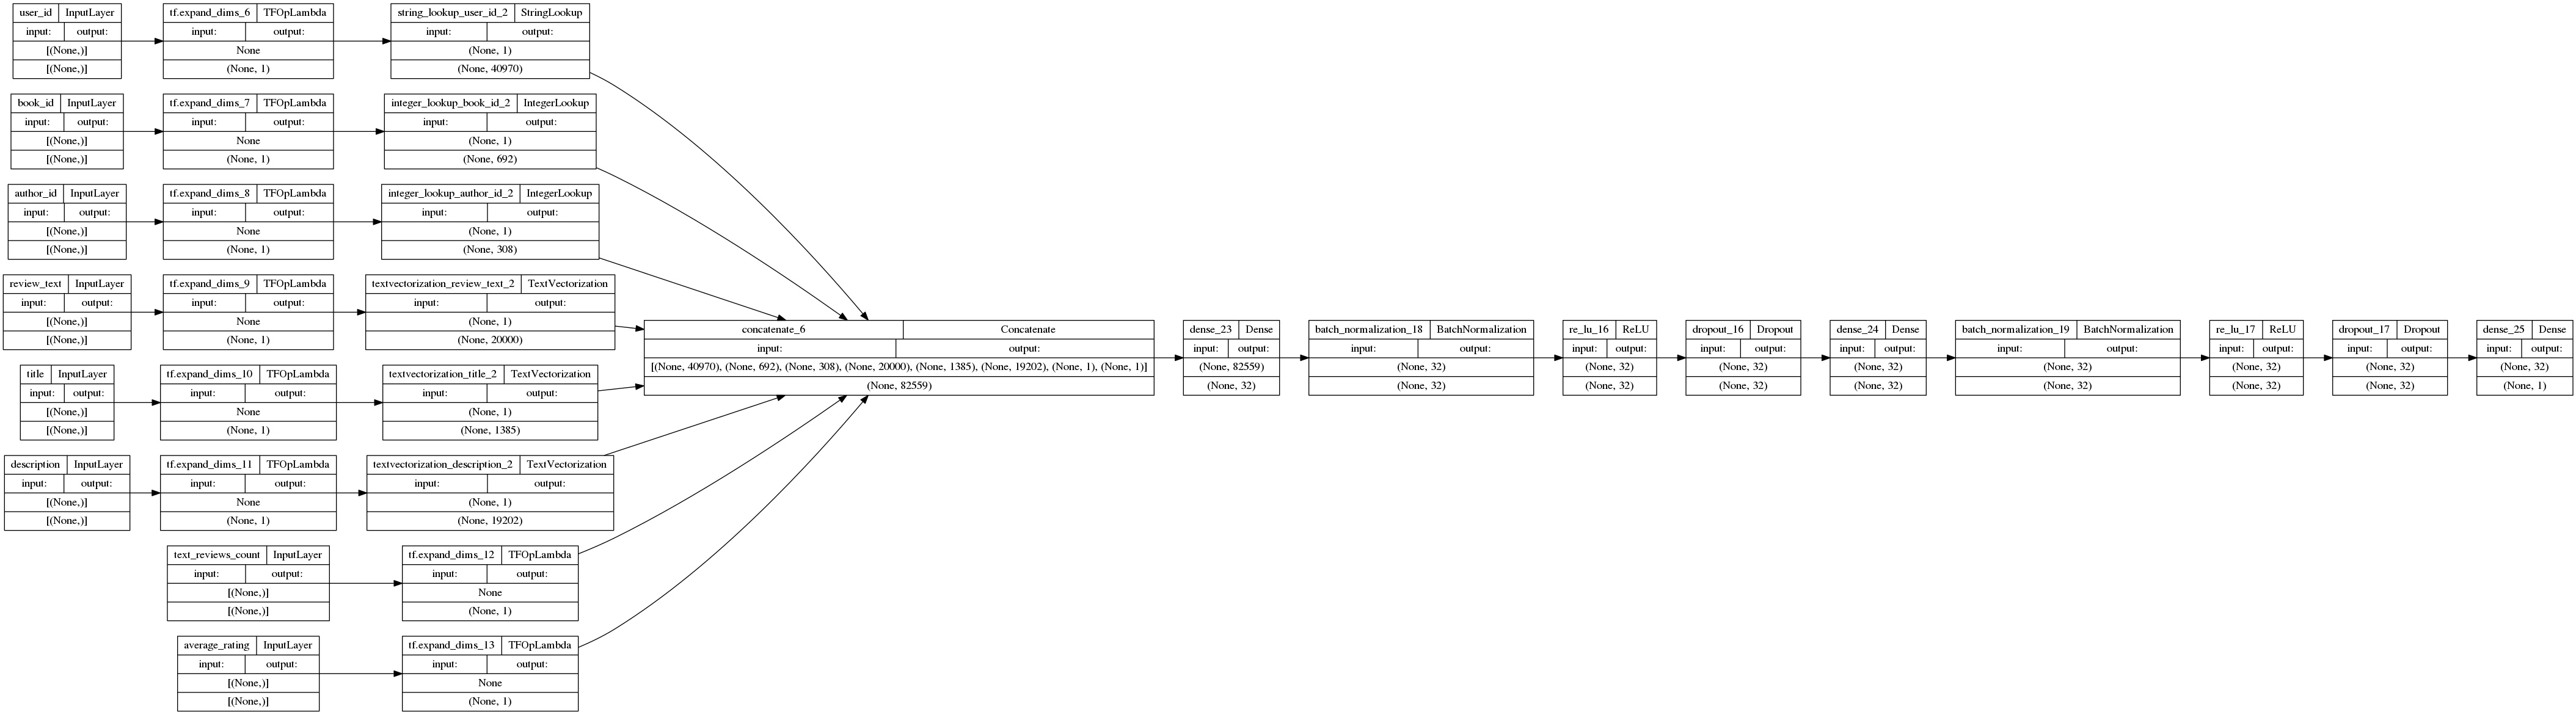

In [101]:
def create_baseline_model():
    inputs = model_inputs
    features = model_features

    for units in hidden_units:
        features = layers.Dense(units)(features)
        features = layers.BatchNormalization()(features)
        features = layers.ReLU()(features)
        features = layers.Dropout(dropout_rate)(features)

    outputs = layers.Dense(1)(features)
    model = keras.Model(inputs=inputs, outputs=outputs, name="baseline_model")
    return model


baseline_model = create_baseline_model()
plot_fn = os.path.join(PLOT_DIR, "baseline_model_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + ".png")

keras.utils.plot_model(baseline_model, to_file=plot_fn, show_shapes=True, rankdir="LR")


In [102]:
run_experiment(baseline_model)

setting up yagmail...
Start training the model...
Start Training with Model baseline_model, wall clock time: 2022-03-05 21:12:38.872746
[]
Epoch 1/20


2022-03-05 21:12:40.041724: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


  6/547 [..............................] - ETA: 29s - loss: 12.5073 - root_mean_squared_error: 3.5366

2022-03-05 21:12:41,793 WARNING  Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0247s vs `on_train_batch_end` time: 0.0414s). Check your callbacks.


547/547 [==============================] - ETA: 0s - loss: 1.9139 - root_mean_squared_error: 1.3834Starting testing with model baseline_model.
[]
stop testing.
['loss: 1.4331320524215698', 'root_mean_squared_error: 1.1971349716186523']
547/547 [==============================] - 36s 61ms/step - loss: 1.9139 - root_mean_squared_error: 1.3834 - val_loss: 1.4331 - val_root_mean_squared_error: 1.1971 - lr: 0.0100
Epoch 2/20
547/547 [==============================] - ETA: 0s - loss: 1.5094 - root_mean_squared_error: 1.2286Starting testing with model baseline_model.
[]
stop testing.
['loss: 1.4068195819854736', 'root_mean_squared_error: 1.1860942840576172']
547/547 [==============================] - 33s 61ms/step - loss: 1.5094 - root_mean_squared_error: 1.2286 - val_loss: 1.4068 - val_root_mean_squared_error: 1.1861 - lr: 0.0100
Epoch 3/20
546/547 [============================>.] - ETA: 0s - loss: 1.4353 - root_mean_squared_error: 1.1981Starting testing with model baseline_model.
[]
stop tes

(<keras.callbacks.History at 0x7f942724ec40>, None)

In [ ]:
baseline_model.save(os.path.join(MODEL_DIR, "baseline_model_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))

INFO:tensorflow:Assets written to: ./models/baseline_model_20220127-202128\assets


---
## Experiment 2: Wide & Deep model
In the second experiment, we create a Wide & Deep model. The wide part of the model a linear model, while the deep part of the model is a multi-layer feed-forward network.

Use the sparse representation of the input features in the wide part of the model and the dense representation of the input features for the deep part of the model.

Note that every input features contributes to both parts of the model with different representations.



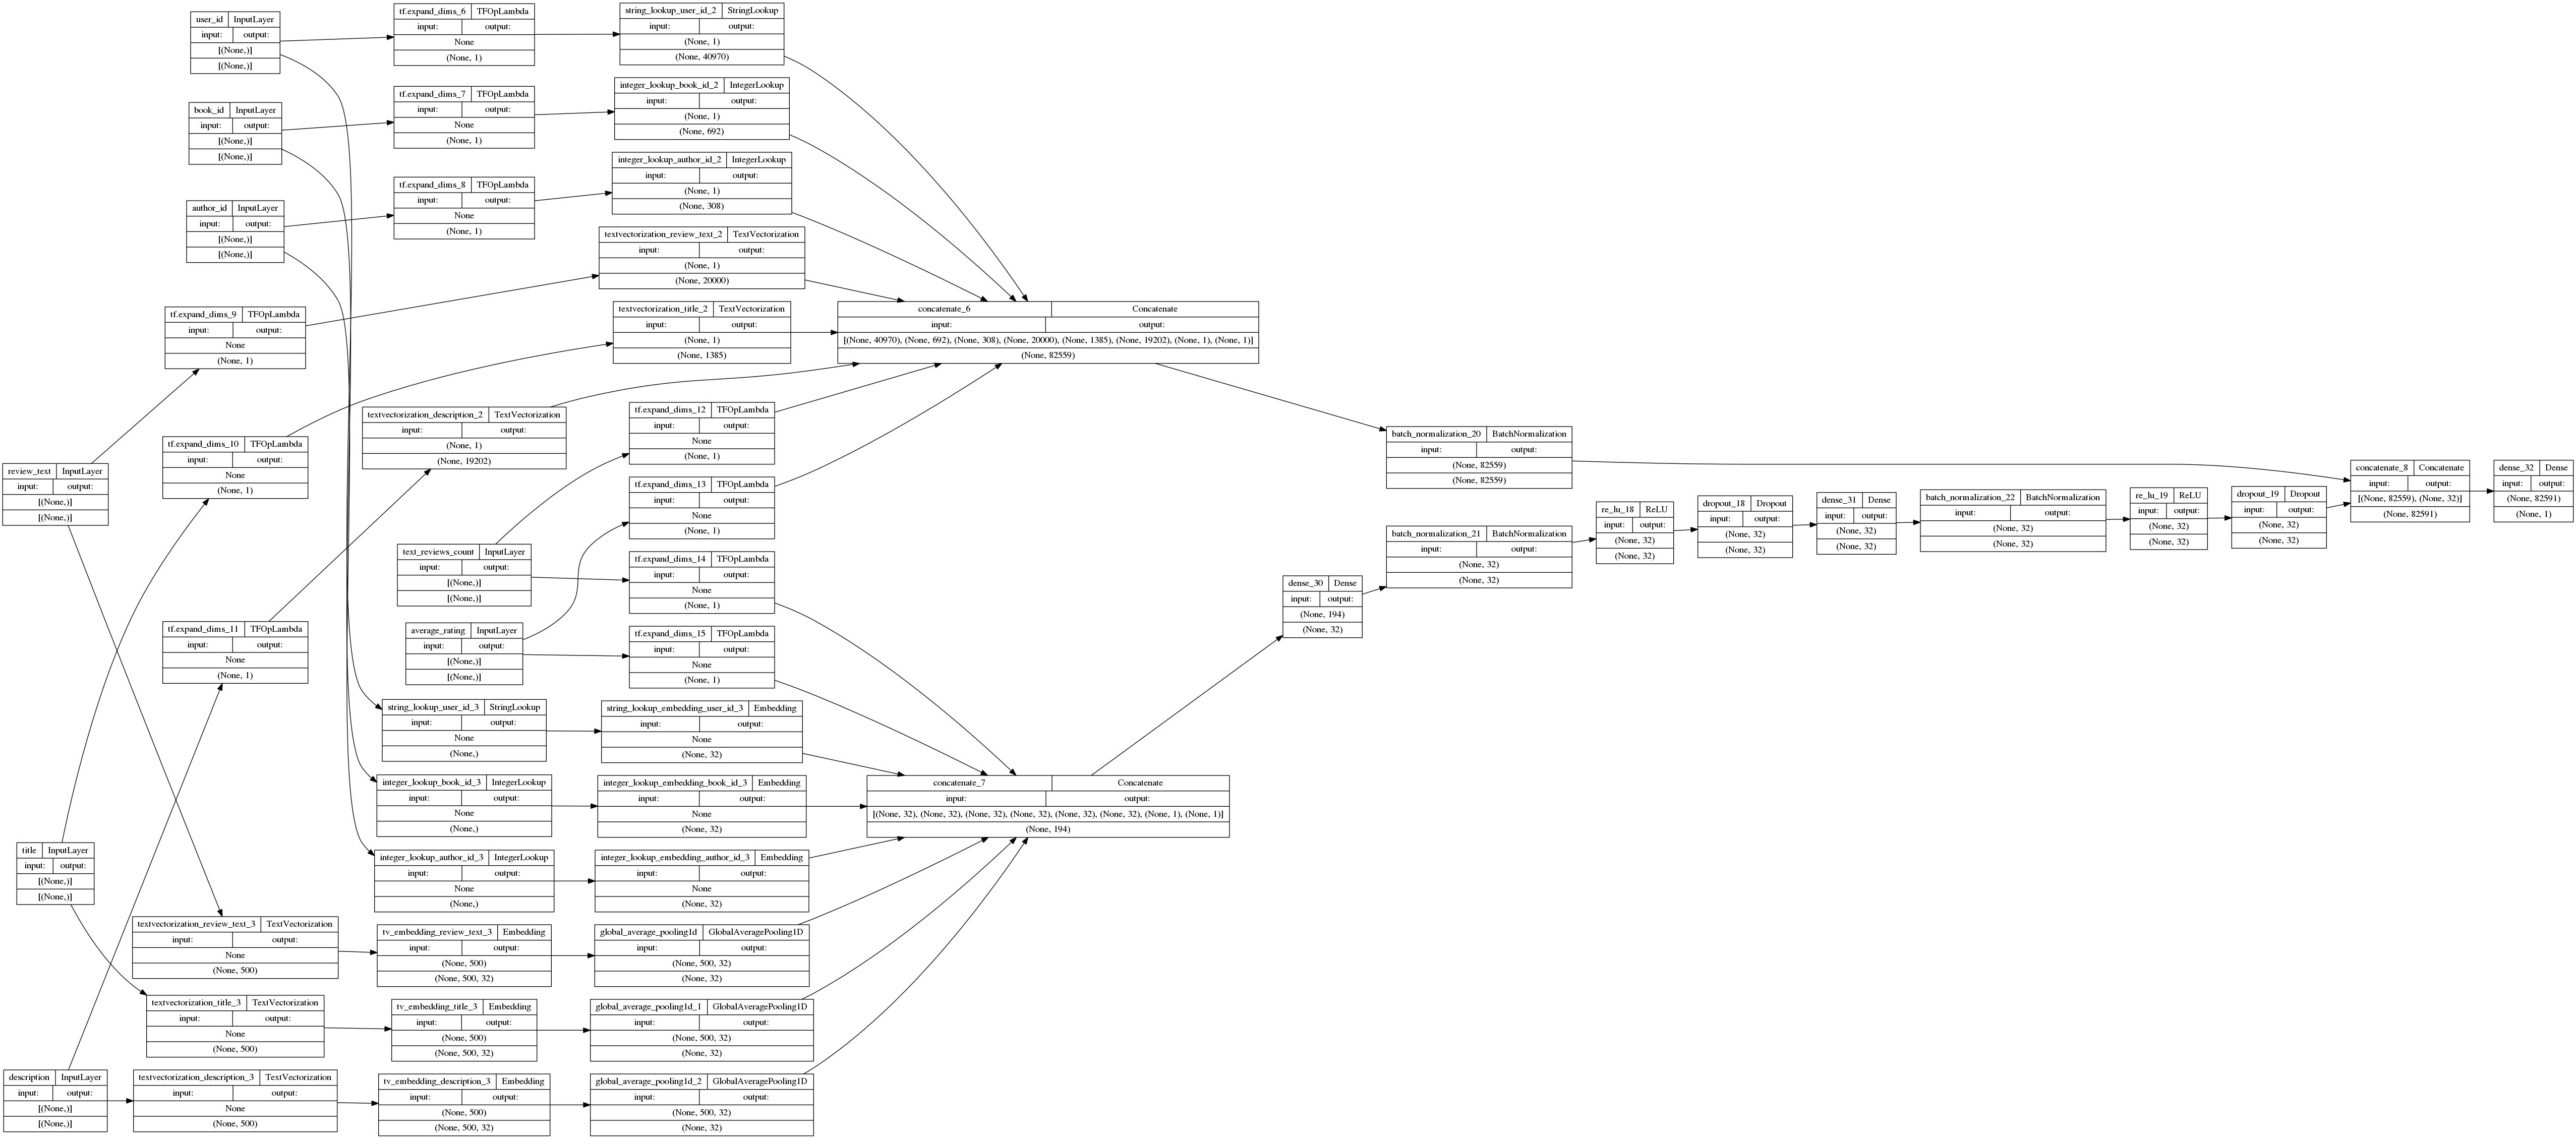

In [108]:
def create_wide_and_deep_model():

    inputs = model_inputs
    wide = model_features
    wide = layers.BatchNormalization()(wide)

    deep = embedded_features
    for units in hidden_units:
        deep = layers.Dense(units)(deep)
        deep = layers.BatchNormalization()(deep)
        deep = layers.ReLU()(deep)
        deep = layers.Dropout(dropout_rate)(deep)

    merged = layers.concatenate([wide, deep])
    outputs = layers.Dense(1)(merged)
    model = keras.Model(inputs=inputs, outputs=outputs, name="wide_and_deep_model")
    return model


wide_and_deep_model = create_wide_and_deep_model()
plot_fn = os.path.join(PLOT_DIR, "wide_and_deep_model_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + ".png")

keras.utils.plot_model(wide_and_deep_model, to_file=plot_fn, show_shapes=True, rankdir="LR")


In [111]:
wide_and_deep_model = create_wide_and_deep_model()
run_experiment(wide_and_deep_model, learning_rate=0.001)

setting up yagmail...
Start training the model...
Start Training with Model wide_and_deep_model, wall clock time: 2022-03-05 21:59:31.964577
[]
Epoch 1/20
547/547 [==============================] - ETA: 0s - loss: 1.6764 - root_mean_squared_error: 1.2947Starting testing with model wide_and_deep_model.
[]
stop testing.
['loss: 1.765790343284607', 'root_mean_squared_error: 1.3288304805755615']
547/547 [==============================] - 68s 118ms/step - loss: 1.6764 - root_mean_squared_error: 1.2947 - val_loss: 1.7658 - val_root_mean_squared_error: 1.3288 - lr: 0.0010
Epoch 2/20
547/547 [==============================] - ETA: 0s - loss: 1.4613 - root_mean_squared_error: 1.2088Starting testing with model wide_and_deep_model.
[]
stop testing.
['loss: 4.517734050750732', 'root_mean_squared_error: 2.1254961490631104']
547/547 [==============================] - 63s 115ms/step - loss: 1.4613 - root_mean_squared_error: 1.2088 - val_loss: 4.5177 - val_root_mean_squared_error: 2.1255 - lr: 0.0010


(<keras.callbacks.History at 0x7f9426792430>, None)

In [ ]:
wide_and_deep_model.save(os.path.join(MODEL_DIR, "wide_and_deep_model_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))

INFO:tensorflow:Assets written to: ./models/wide_and_deep_model_20220127-203343\assets


---
## Experiment 3: Deep & Cross model
In the third experiment, we create a Deep & Cross model. The deep part of this model is the same as the deep part created in the previous experiment. The key idea of the cross part is to apply explicit feature crossing in an efficient way, where the degree of cross features grows with layer depth.

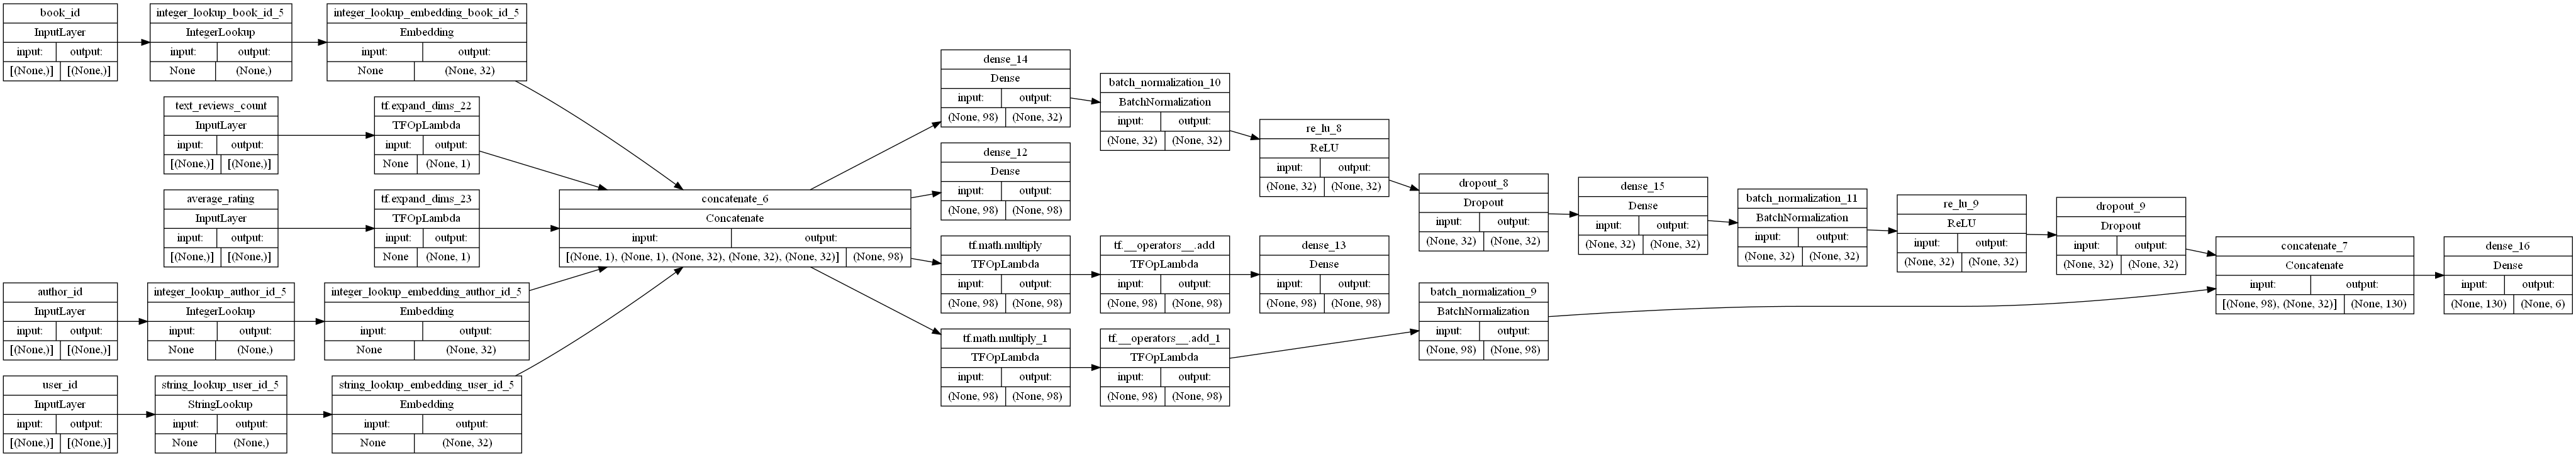

In [ ]:
def create_deep_and_cross_model():

    inputs = model_inputs
    x0 = embedded_features

    cross = x0
    for _ in hidden_units:
        units = cross.shape[-1]
        x = layers.Dense(units)(cross)
        cross = x0 * x + cross
    cross = layers.BatchNormalization()(cross)

    deep = x0
    for units in hidden_units:
        deep = layers.Dense(units)(deep)
        deep = layers.BatchNormalization()(deep)
        deep = layers.ReLU()(deep)
        deep = layers.Dropout(dropout_rate)(deep)

    merged = layers.concatenate([cross, deep])
    outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(merged)
    model = keras.Model(inputs=inputs, outputs=outputs, name="deep_and_cross_model")
    return model


deep_and_cross_model = create_deep_and_cross_model()
plot_fn = os.path.join(PLOT_DIR, "deep_and_cross_model_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + ".png")

keras.utils.plot_model(deep_and_cross_model, to_file=plot_fn, show_shapes=True, rankdir="LR")


In [ ]:
run_experiment(deep_and_cross_model)

setting up yagmail...
Start training the model...
Start Training with Model...
Starting training; got log keys: []
[]
Epoch 1/20


C:\Users\simon\anaconda3\envs\ds-project\lib\site-packages\keras\engine\functional.py:559: UserWarning: Input dict contained keys ['review_text', 'title', 'description'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


313/313 [==============================] - 20s 41ms/step - loss: 1.5633 - sparse_categorical_accuracy: 0.3415 - sparse_categorical_crossentropy: 1.5633
Epoch 2/20
313/313 [==============================] - 11s 37ms/step - loss: 1.3368 - sparse_categorical_accuracy: 0.4466 - sparse_categorical_crossentropy: 1.3368
Epoch 3/20
313/313 [==============================] - 13s 41ms/step - loss: 1.1510 - sparse_categorical_accuracy: 0.5423 - sparse_categorical_crossentropy: 1.1510
Epoch 4/20
313/313 [==============================] - 13s 42ms/step - loss: 0.8754 - sparse_categorical_accuracy: 0.6516 - sparse_categorical_crossentropy: 0.8754
Epoch 5/20
313/313 [==============================] - 13s 42ms/step - loss: 0.7155 - sparse_categorical_accuracy: 0.7006 - sparse_categorical_crossentropy: 0.7155
Epoch 6/20
313/313 [==============================] - 18s 58ms/step - loss: 0.6057 - sparse_categorical_accuracy: 0.7385 - sparse_categorical_crossentropy: 0.6057
Epoch 7/20
313/313 [=============

(<keras.callbacks.History at 0x267c5fd4460>,
 [5.4389495849609375, 0.384116530418396, 5.4389495849609375])

In [ ]:
deep_and_cross_model.save(os.path.join(MODEL_DIR, "deep_and_cross_model_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))

INFO:tensorflow:Assets written to: ./models/deep_and_cross_model_20220127-204018\assets
